### Cost-Effective Alzheimer's Diagnostics

Import libraries

In [ ]:
%matplotlib inline
from IPython.display import display
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from statsmodels.api import OLS
from statsmodels.tools import add_constant
import datetime
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn.apionly as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
import sys
import urllib
import warnings

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

## Data Loading, Cleaning, and EDA


Read in ADNIMERGE and CSF datasets:

In [ ]:
adnimerge = pd.read_csv('ADNIMERGE.csv')
csf = pd.read_csv('UPENNBIOMK_MASTER.csv')

print(adnimerge.shape)
print(csf.shape)

**Preliminary data cleaning:**

CSF measurements are taken in multiple batches. The UPENN dataset includes the median of values across batches, which act as a summary value for each patient/timepoint. These median values will be used for analyses.


In [ ]:
csf_bl = csf.loc[csf['VISCODE']=='bl'].loc[csf['BATCH']=='MEDIAN'] #baseline csf values
csf_bl = csf_bl.drop(['ABETA_RAW', 'TAU_RAW', 'PTAU_RAW'], axis=1) #drop raw data (use only scaled data)

adnimerge_bl = adnimerge.loc[adnimerge['VISCODE']=='bl'] #baseline adnimerge values

adnimerge_bl = adnimerge_bl.drop('M', axis=1)
adnimerge_bl = adnimerge_bl.drop(['EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl',
       'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
       'RAVLT_perc_forgetting_bl', 'FAQ_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_blxa',
       'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl',
       'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl',
       'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl',
       'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
       'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl',
       'AV45_bl', 'Years_bl', 'Month_bl'], axis=1)

Merge ADNIMERGE and CSF:

In [ ]:
merged_dx = pd.merge(left=adnimerge_bl, right=csf_bl, left_on='RID', right_on='RID', how='left')

The outcome of interest (autopsy-proven diagnosis) is stored in the column 'DX_bl'.

In [ ]:
print("No. of missing values in 'DX_bl':", merged_dx['DX_bl'].isnull().sum())

Collapse dx_bl into 3 categories, coded as follows:
- CN (CN+SMC) = 1
- MCI (LMCI+EMCI) = 2
- AD = 3

In [ ]:
merged_dx['Base_DX']= merged_dx['DX_bl'].copy()
merged_dx.loc[merged_dx['DX_bl']=='SMC','Base_DX'] = 0
merged_dx.loc[merged_dx['DX_bl']=='CN','Base_DX'] = 0
merged_dx.loc[merged_dx['DX_bl']=='EMCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='LMCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='MCI','Base_DX'] = 1
merged_dx.loc[merged_dx['DX_bl']=='AD','Base_DX'] = 2

In [ ]:
print('observations per protocol:')
merged_dx['COLPROT'].value_counts()

Extract ADNI2 data:

In [ ]:
adnitwo = merged_dx.loc[merged_dx['COLPROT']=='ADNI2']
print('shape of extracted ADNI data: ', adnitwo.shape)

Drop columns with large proportion of missing values:

In [ ]:
#drop 'FLDSTRENG' and 'FSVERSION' variables (unknown meaning and missing values)
adnitwo = adnitwo.drop(['FLDSTRENG', 'FSVERSION', 'FLDSTRENG_bl', 'FSVERSION_bl'], axis=1)

#drop PIB (not measured in ADNI2)
adnitwo = adnitwo.drop(['PIB', 'PIB_bl'], axis=1)

print('shape after dropping empty/sparse columns: ', adnitwo.shape)
print('\nNumber of missing values for remaining features:')
for col in adnitwo.columns:
    print(col, adnitwo[col].isnull().sum())

Rows with remaining missing values:

In [ ]:
plt.hist(adnitwo.isnull().sum(axis=1), bins=100) #To find the number of missing datapoints in each row
plt.title('Histogram of Number of Missing Values Per Patient')
plt.xlabel("Number of missing values")
plt.ylabel("Number of patients")
plt.show()

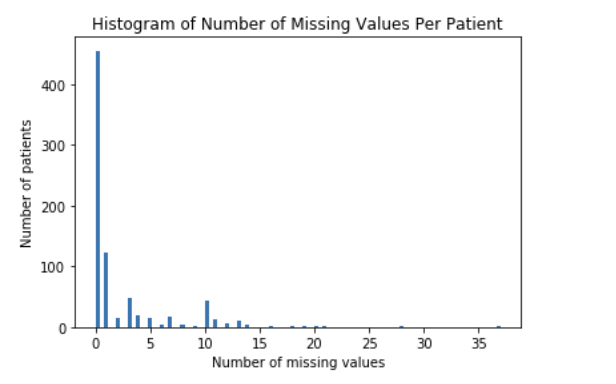 Based on the histogram above, the majority of observations contain zero missing values, but there is still a tail of observations containing some missing values. If we drop all observations with missing values, then the total number of observations remaining is:

In [ ]:
adnitwo_full = adnitwo.dropna(axis='rows')
print('No. of observations without any missing values:', adnitwo_full.shape[0])

We can retain a larger proportion of observations by dropping only observations with ≥10 missing values and imputing remaining missing values.

In [ ]:
threshold = adnitwo.shape[1] - 10
adnitwo_dropten = adnitwo.dropna(axis='rows', thresh=threshold) #thresh = min # of non-NaN values
print('Number of rows after dropping those with ≥10 NaNs:', adnitwo_dropten.shape[0])

In [ ]:
print('\nNumbers of Missing Values per Feature After Removing Observations with ≥10 NaNs:')
for col in adnitwo.columns:
    print(col, adnitwo[col].isnull().sum())

Mean imputation to fill in remaining missing values:

In [ ]:
#list of column names for columns containing NaNs
cols_with_na=[]

for column in adnitwo_dropten:
    if adnitwo_dropten[column].isnull().any()==True:
        cols_with_na.append(column)

#impute means
meandf = adnitwo_dropten.copy()
for col in cols_with_na:
    if adnitwo_dropten[col].dtype=='float64':
        meandf[col] = adnitwo_dropten[col].fillna(adnitwo_dropten[col].mean())
    else: #for non-numeric data
        meandf[col] = adnitwo_dropten[col].fillna(adnitwo_dropten[col].mode()[0])

#confirm imputation success
#np.any(pd.isnull(meandf))  #If `False`, confirms that meandf is now Nan-free

## Feature Engineering

In [ ]:
adnimerge.shape

In [ ]:
adnimerge[adnimerge['COLPROT']== 'ADNI2'].groupby('VISCODE').count()['RID']

- 679 of the total ADNI2 patients had a follow up visit at t= m24


In [ ]:
adni2_m24_brainvol = adnimerge.loc[adnimerge['COLPROT']=='ADNI2'].loc[adnimerge['VISCODE'] == 'm24'][['RID','WholeBrain']]

In [ ]:
adni2_m24_brainvol.head()

In [ ]:
#add a prefix to column name
adni2_m24_brainvol=adni2_m24_brainvol.add_prefix('m24_')

#merge m24 brain vol data with meandf
merged_meandf_m24 = pd.merge(left=meandf, right=adni2_m24_brainvol, left_on='RID', right_on='m24_RID', how='left')

In [ ]:
#checking number of cases with CN, MCI and AD
merged_meandf_m24['Base_DX'].value_counts()

## Preprocessing

In [ ]:
merged_meandf_m24.columns

In [ ]:
categorical_variables = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']
modeldf = pd.get_dummies(merged_meandf_m24, columns=categorical_variables, drop_first=True)
modeldf.columns #confirm appropriate one-hot encoding

Drop variables that are not useful for prediction:

In [ ]:
data_full = modeldf.drop(['RID', 'PTID', 'VISCODE_x', 'SITE', 'COLPROT', 'ORIGPROT',
                           'EXAMDATE', 'DX_bl', 'PTEDUCAT', 'update_stamp_x', 'update_stamp_y',
                          'm24_RID', 'm24_WholeBrain', 'VISCODE_y', 'BATCH',
                            'KIT', 'STDS', 'DRWDTE', 'RUNDATE', 'DX', 'Month', 'CDRSB'], axis=1)

data_full['Base_DX'] = data_full['Base_DX'].apply(pd.to_numeric)
data_full.head()

#X = data_full.iloc[:, :-1].values
#y = data_full['Base_DX']

#X = modeldf[usefulcols].values[:,:-1]
#y = modeldf[usefulcols].values[:,-1]

Split data into training set and test set (70-25 split):


In [ ]:
data_train, data_test = train_test_split(data_full, test_size = 0.25, random_state=9001)
data_train.shape, data_test.shape

Standardize predictors:

In [ ]:
cont_cols = ['AGE', 'FDG', 'AV45', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV','ABETA',
       'TAU', 'PTAU']

stdz_train = data_train.copy()
stdz_test = data_test.copy()

def stdit(a,a_mean,a_std):                                        #Standardizing continous data to be used in classification model
    a = float(a)
    a=(a-a_mean)/(a_std)
    return a

for col in cont_cols:
    a_mean = data_train[col].mean()
    a_std = data_train[col].std()
    stdz_train[col] = stdz_train[col].apply(lambda s: stdit(s,a_mean,a_std))
    stdz_test[col] = stdz_test[col].apply(lambda s: stdit(s,a_mean,a_std))

Further split training set into train and validation for model selection (80-20 split):

In [ ]:
stdz_train_fs, stdz_val = train_test_split(stdz_train, test_size = 0.20, random_state=9001)

Define X and y datasets for model fitting:

In [ ]:
X_train = stdz_train_fs.drop('Base_DX', axis=1).values
y_train = stdz_train_fs['Base_DX'].values
X_val = stdz_val.drop('Base_DX', axis=1).values
y_val = stdz_val['Base_DX'].values
X_test = stdz_test.drop('Base_DX', axis=1).values
y_test = stdz_test['Base_DX'].values

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

## Baseline Classification Models

#### Model Selection

- Six different models were trained on the training set for performance and the best model was selected through cross-validation. Hold-out cross-validation was used instead of k-fold considering small size of the dataset.

In [ ]:
score = lambda model, X_train, y_train, X_val, y_val : pd.Series([model.score(X_train, y_train), model.score(X_val, y_val)],index=['Model Training Accuracy', 'Model Validation Accuracy'])

In [ ]:

# multinomial logistic regression
clf_mult = LogisticRegressionCV(multi_class='multinomial')
clf_mult.fit(X_train, y_train)
clf_mult_score = score(clf_mult,X_train,y_train,X_val,y_val)

# one-vs-rest (OvR) logistic regression
clf_ovr = LogisticRegressionCV(multi_class='ovr')
clf_ovr.fit(X_train, y_train)
clf_ovr_score = score(clf_ovr,X_train,y_train,X_val,y_val)

# Linear Discriminant Analysis
lda = LDA()
lda.fit(X_train, y_train)
lda_score = score(lda,X_train,y_train,X_val,y_val)

# Quadratic Discriminant Analysis
qda = QDA()
qda.fit(X_train, y_train)
qda_score = score(qda,X_train,y_train,X_val,y_val)

# k-Nearest Neighbors
cv_scores = []
neighbors = range(1,30)

for k in neighbors:
    knn = KNN(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

knn = KNN(n_neighbors = optimal_k)
knn.fit(X_train, y_train)
knn_score = score(knn,X_train,y_train,X_val,y_val)

# Decision Tree
cv_scores = []
depths = range(1,50)

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, class_weight='balanced', criterion='entropy')
    scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_d = depths[cv_scores.index(max(cv_scores))]

tree = DecisionTreeClassifier(max_depth=optimal_d, class_weight='balanced', criterion='entropy')
tree.fit(X_train, y_train)
tree_score = score(tree,X_train,y_train,X_val,y_val)

In [ ]:
score_df = pd.DataFrame({'knn': knn_score,
                         'clf_multinomial': clf_mult_score,
                         'clf_ovr': clf_ovr_score,
                         'lda': lda_score,
                         'qda': qda_score, 'tree': tree_score})
score_df

From the table generated above, multinomial logistic regression performs the best.

In [ ]:
#calculating performance of best model on test set
clf_mult_tscore = clf_mult.score(X_test, y_test)


In [ ]:
print("Classification accuracy of the multinomial logistic regression on the test set is: ",clf_mult_tscore)

In [ ]:
optimal_d

In [ ]:
stdz_train_fs.columns

Now, bundle predictors from each of the screens together. Then calculate the screen's contribution to overall model's accuracy by running the model by removing predicors from each bundle one at a time.

In [ ]:
# contribution of each bundle to accuracy

dem = ['AGE', 'PTGENDER_Female','PTETHCAT_Hisp/Latino', 'PTETHCAT_Not Hisp/Latino', 'PTRACCAT_Am Indian/Alaskan',
 'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI', 'PTRACCAT_More than one',
 'PTRACCAT_White', 'PTMARRY_Divorced', 'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Widowed']
gen = ['APOE4_1.0', 'APOE4_2.0']
adas = ['ADAS13']
mmse = ['MMSE']
ravlt = ['RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting']
faq = ['FAQ']
moca =['MOCA']
ecogpt = ['EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal']
ecogsp = ['EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal']
mri = ['Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
pet = ['FDG', 'AV45']
csf = ['ABETA',
       'TAU', 'PTAU']


In [ ]:
pred_types = {'Demographic':dem, 'Genetic':gen, 'ADAS':adas, 'MMSE':mmse, 'RAVLT':ravlt,'FAQ': faq, 'MOCA':moca, 'ECogPt':ecogpt, 'ECogSP':ecogsp, 'MRI':mri,
                   'PET':pet,'CSF':csf}

In [ ]:
all_preds = list(stdz_train_fs.drop('Base_DX', axis=1).columns)
accwithout = {}

#To calculate importance of each predictor to accuracy
curr_preds = list(stdz_train_fs.drop('Base_DX', axis=1).columns)

#Get values for train and validation (instead of test)
for key in pred_types.keys():
    this_time = [a for a in curr_preds if a not in pred_types[key]]

    X_subtrain= stdz_train_fs[this_time].values
    X_subtest = stdz_test[this_time].values

    clf_mult.fit(X_subtrain, y_train)
    accwithout[key] = (clf_mult.score(X_subtrain,y_train),clf_mult.score(X_subtest,y_test))


accwithout

## Backward Selection

Next, perform backward selection to arrive at the feature set with the least number of predictors.



In [ ]:
#get subset of best bundle of predictors
#backword selection using validation accuracy

def sw_back_selection(model,train_df,val_df, pred_types):
    curr_types = pred_types.copy()
    all_preds = list(train_df.columns)[:-1]
    X_subtrain= train_df.iloc[:, :-1].values
    y_subtrain = train_df.iloc[:,-1].values
    X_subval = val_df.iloc[:,:-1].values
    y_subval = val_df.iloc[:,-1].values
    clf_mult.fit(X_subtrain, y_subtrain)
    predictors = [(all_preds, "none",clf_mult.score(X_subval,y_subval))]
    for k in range(len(pred_types),1,-1):
        best_k_predictors = predictors[-1][0]
        val_acc = {}
        for key in curr_types.keys():
            this_time = [a for a in best_k_predictors if a not in curr_types[key]]
            X_subtrain= train_df[this_time].values
            X_subval = val_df[this_time].values
            clf_mult.fit(X_subtrain, y_subtrain)
            val_acc[key] = clf_mult.score(X_subval,y_subval)
        best_k_minus_1 = list(set(best_k_predictors) - set(curr_types[list(val_acc.keys())[np.argmax(list(val_acc.values()))]]))
        del curr_types[list(val_acc.keys())[np.argmax(list(val_acc.values()))]]
        predictors.append((best_k_minus_1, list(val_acc.keys())[np.argmax(list(val_acc.values()))],np.max(list(val_acc.values()))))
    return predictors


In [ ]:
selection_res = sw_back_selection(clf_mult,stdz_train_fs,stdz_val,pred_types)
#print("Best subset ofa predictors is {} with a validation accuracy of {}".format(best_back_selection[0],best_back_selection[1]))

In [ ]:
best_back_selection = sorted(selection_res, key=lambda t: t[2],reverse=True)[0]

The backwards selection process results in dropping the following predictors:

In [ ]:
dropped = []
for i in range(1,8):
    dropped.append(selection_res[i][1])
print('Predictors dropped:', dropped)

In [ ]:
print('Remaining predictors after backward selection:', selection_res[7][0])

## Predictor Importance Versus Estimated Cost

Assess the monetary costs and potential savings of various predictor bundles to identify the most cost-effective indicators for Alzheimer's. Predictor costs are estimated based on the direct expenses of clinical tests, as detailed in the accompanying website report. The projected savings reflect the benefits of early Alzheimer's detection, which enables timely intervention and reduces healthcare system costs. These savings are calculated according to the methods outlined in the website report.








In [ ]:
acc_inc = list(np.array(list(accwithout.values()))[:,1]-0.75)
test_C = [192, 463, 0, 192, 192, 192, 149, 192, 192, 1102, 7700, 192]
det_T = [3, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3] #1 is highest savings (early detection); 3 is late detection
tot_C = [12050, 6392, 5929, 12050, 12050, 12050, 149, 12050, 12050, 12960, 19558, 12050]
bundles = ['ADAS','CSF','Demographic','ECogPt','ECogSP','FAQ','Genetic','MMSE','MOCA','MRI','PET','RAVLT']

Predictors were grouped into bundles based on shared costs (e.g., all MRI metrics are derived from the cost of a single brain MRI). The contribution of each predictor bundle to model accuracy was determined by comparing the accuracy of the full model to versions with each bundle of predictors removed, evaluated individually for each bundle. In every case, removing a predictor set led to a reduction in model accuracy. The absolute decrease in accuracy from excluding a predictor bundle represents that bundle's contribution to model accuracy.








In [ ]:
plt.scatter(acc_inc, test_C)
plt.title('Cost vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Test Bundle Cost ($)')
for (i,x,y) in zip(bundles,acc_inc,test_C):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

The ability of a test bundle to detect Alzheimer's earlier versus later is an added bonus to that bundle's utility. Detection timing and associated savings were estimated as detailed in the report. Below we plot the timing of detection (1=earliest possible detection, 2=medium timing, 3=latest possible detection) against bundle importance to the model.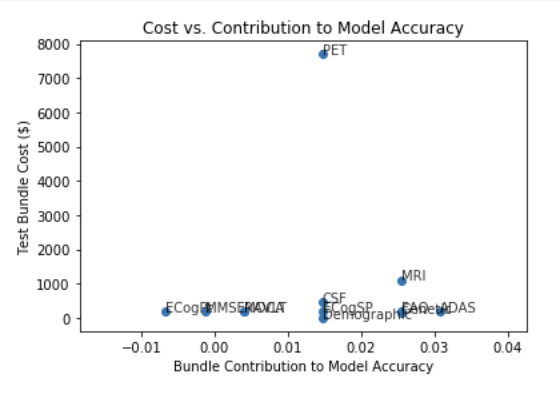

In [ ]:
### CONSIDER WAYS TO REFORMAT THIS GRAPH AS 'EARLY' 'MEDIUM' 'LATE' INSTEAD OF CONTINUOUS Y AXIS


plt.scatter(acc_inc,det_T)
plt.title('Stage of Detection vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Stage of Detection (early to late)')
for (i,x,y) in zip(bundles,acc_inc,det_T):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

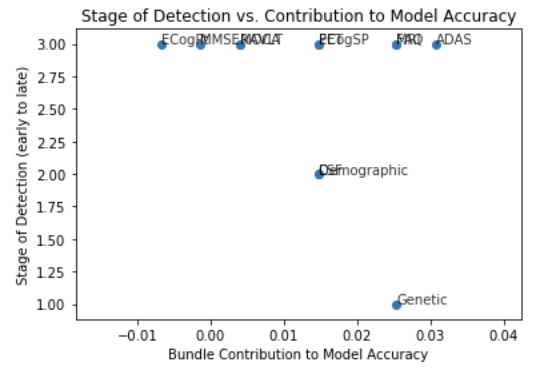

Below, combine costs and savings from early detection by treating the absence of savings from late detection as an added cost. This combined metric is calculated as the sum of the absolute values of costs and potential savings for each predictor bundle.








In [ ]:
plt.scatter(acc_inc,tot_C)
plt.title('Cost Summary vs. Contribution to Model Accuracy')
plt.xlabel('Bundle Contribution to Model Accuracy')
plt.ylabel('Cost Summary ($)')
for (i,x,y) in zip(bundles,acc_inc,tot_C):
    plt.annotate(i,xy=(x,y), alpha=.8)
plt.show()

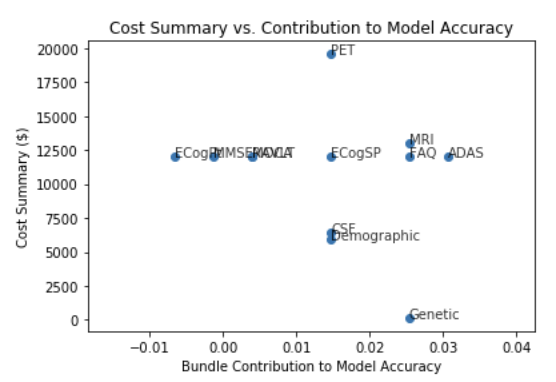

The genetic bundle (comprised only of APOE4 in this analysis) provides the greatest contribution to model accuracy for the least overall cost.

### Alzheimer's Disease Prediction

import libraries

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

Define parameters

In [ ]:
num_patients = 100  # Number of patients
num_visits = 5  # Number of visits (time steps)
num_features = 8  # Number of features including additional biomarkers

Simulate data including biomarkers such as APOE ε4, CSF Aβ42, total tau, NfL, etc.


In [ ]:
longitudinal_data = np.random.rand(num_patients, num_visits, num_features)
labels = np.random.randint(2, size=num_patients)  # Binary labels (Alzheimer's vs. Normal)

Standardize the feature values

In [ ]:
scaler = StandardScaler()
longitudinal_data = longitudinal_data.reshape(-1, num_features)  # Flatten data for scaling
longitudinal_data = scaler.fit_transform(longitudinal_data)
longitudinal_data = longitudinal_data.reshape(num_patients, num_visits, num_features)  # Reshape back

Build the Updated Bidirectional LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input

 Define the Bidirectional LSTM model

In [ ]:
model = Sequential([
    Input(shape=(num_visits, num_features)),  # Input shape (timesteps, features)

    # First Bidirectional LSTM layer
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.3),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(32, activation='tanh')),
    Dropout(0.3),

    # Dense layers for higher-level feature extraction
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

Compile the model


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train the model with learning rate scheduler

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Add to model.fit along with the learning rate scheduler
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=16, callbacks=[lr_scheduler, early_stopping])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(longitudinal_data, labels, test_size=0.2, random_state=42)

# Train the model
epochs = 20
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


Plot model accuracy

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

Evaluate model performance on the test set

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [ ]:
model.save('alzheimers_bidirectional_lstm_model_with_biomarkers.h5')